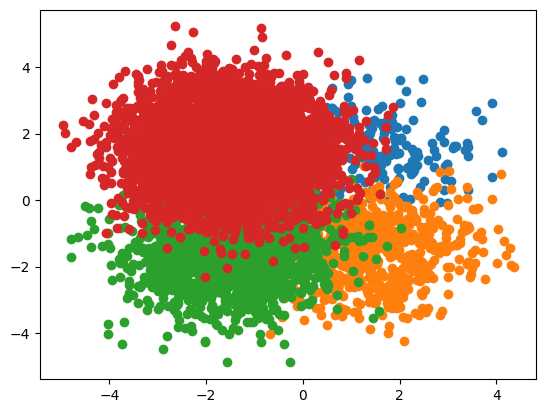

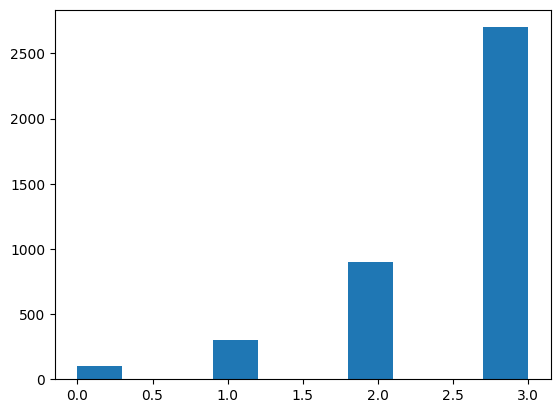

In [91]:
import torch
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from misc.metrics import *

samples_0 = torch.randn(200,2)+torch.tensor([1.5,1.5])
samples_1 = torch.randn(600,2)+torch.tensor([1.5,-1.5])
samples_2 = torch.randn(1800,2)+torch.tensor([-1.5,-1.5])
samples_3 = torch.randn(5400,2)+torch.tensor([-1.5,1.5])
plt.scatter(samples_0[:,0].numpy(),samples_0[:,1].numpy())
plt.scatter(samples_1[:,0].numpy(),samples_1[:,1].numpy())
plt.scatter(samples_2[:,0].numpy(),samples_2[:,1].numpy())
plt.scatter(samples_3[:,0].numpy(),samples_3[:,1].numpy())
plt.show()

samples = torch.cat([samples_0, samples_1, samples_2, samples_3])
labels = torch.cat([torch.zeros(100), torch.ones(300), 2*torch.ones(900), 3*torch.ones(2700)]).long()

plt.hist(labels.numpy())
plt.show()

In [92]:
class GaussianClassifier:
    def __init__(self,samples, labels,mu = None, Psi=None, lbda = None, nu = None):
        self.samples = samples
        self.labels = labels
        self.sample_dim = samples.shape[-1]
        self.C = labels.shape[-1]
        
        if mu is not None:
            self.mu = mu
        else:
            self.mu = torch.zeros(self.sample_dim)
            
        if Psi is not None:
            self.Psi = Psi
        else: 
            self.Psi = torch.eye(self.sample_dim)   
            
        if lbda is not None:
            self.lbda = lbda
        else: 
            self.lbda = 1 
            
        if Psi is not None:
            self.nu = nu
        else: 
            self.nu = 10
            
    
    def sample_theta_from_prior(self,num_samples):
        Sigma_prior = torch.inverse(torch.distributions.Wishart(self.nu,torch.inverse(self.Psi)).sample(num_samples+[self.C]))
        mean_prior = torch.distributions.MultivariateNormal(self.mu.unsqueeze(0).repeat(self.C,1),Sigma_prior/self.lbda).sample()
        return mean_prior, Sigma_prior
    
    def sample_theta_from_posterior(self,num_samples, samples=None, labels=None):
        list_Sigma = []
        list_mean = []
        if samples is None: 
            samples = self.samples
        if labels is None:
            labels = self.labels
        for c in range(self.C):
            samples_c = samples[labels[:,c]==1.]
            N_c = samples_c.shape[0]
            lbda_N_c = self.lbda + N_c
            nu_N_c = self.nu + N_c
            empirical_mean_c = torch.mean(samples_c, dim =0)
            mu_N_c = (self.lbda*self.mu + N_c*empirical_mean_c)/lbda_N_c
            S_c = torch.cov(samples_c.T)*(N_c-1)
            temp = (empirical_mean_c-self.mu).unsqueeze(-1)
            Psi_N_c = self.Psi + S_c + (self.lbda*N_c*temp@temp.T)/(lbda_N_c)
            Sigma_c = torch.inverse(torch.distributions.Wishart(nu_N_c,torch.inverse(Psi_N_c)).sample(num_samples))
            mean_c = torch.distributions.MultivariateNormal(mu_N_c,Sigma_c/self.lbda).sample()
            list_Sigma.append(Sigma_c.unsqueeze(1))
            list_mean.append(mean_c.unsqueeze(1))
        return torch.cat(list_mean, dim = 1), torch.cat(list_Sigma, dim = 1)
    
    def log_prob(self,samples, means, Sigmas, prior):
        log_prob = torch.distributions.MultivariateNormal(means, Sigmas).log_prob(samples.unsqueeze(1).unsqueeze(2).repeat(1,means.shape[0], self.C,1))+torch.log(prior.unsqueeze(0).unsqueeze(0).repeat(samples.shape[0], means.shape[0],1))
        return log_prob - torch.logsumexp(log_prob, dim = -1, keepdim =True)
        
    def log_posterior_prob(self,betas):
        return torch.sum(self.log_prob(self.samples, betas)*self.labels.unsqueeze(0).repeat(betas.shape[0],1,1),dim = [-2,-1]) + torch.distributions.MultivariateNormal(self.mu_beta, self.Sigma_beta).log_prob(betas)
    
    def predict_with_gibbs(self,test_samples, prior, T = 500):
        list_log_prob = []
        means, Sigmas = self.sample_theta_from_posterior([1])
        log_prob = self.log_prob(test_samples, means, Sigmas, prior)[:,0,:]
        list_log_prob.append(log_prob)
        predicted = torch.distributions.Categorical(log_prob).sample()
        for i in range(T):
            total_samples = torch.cat([self.samples, test_samples], dim  = 0)
            total_labels = torch.cat([self.labels, torch.nn.functional.one_hot(predicted, num_classes = self.C)], dim = 0)
            means, Sigmas = self.sample_theta_from_posterior([1], samples = total_samples, labels  = total_labels)
            log_prob = self.log_prob(test_samples, means, Sigmas, prior)[:,0,:]
            list_log_prob.append(log_prob)
            predicted = torch.distributions.Categorical(log_prob).sample()
        return torch.mean(torch.exp(torch.cat(list_log_prob)), dim = 0)
            
        

tensor([0.4000, 0.3000, 0.2000, 0.1000])


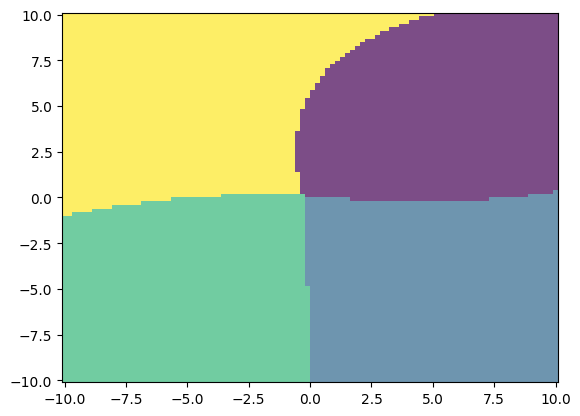

In [87]:
model = GaussianClassifier(samples, torch.nn.functional.one_hot(labels))
mean_posterior,Sigma_posterior = model.sample_theta_from_posterior([1000])
from utils import * 
prior = torch.tensor([4,3,2,1])
prior = prior/torch.sum(prior)
print(prior)
plot_2d_function(lambda samples: torch.argmax(torch.mean(torch.exp(model.log_prob(samples,mean_posterior,Sigma_posterior, prior)), dim = 1),dim = -1), bins = [100,100], range = [[-10,10],[-10,10]])

tensor([0.4369, 0.2984, 0.1800, 0.0847])


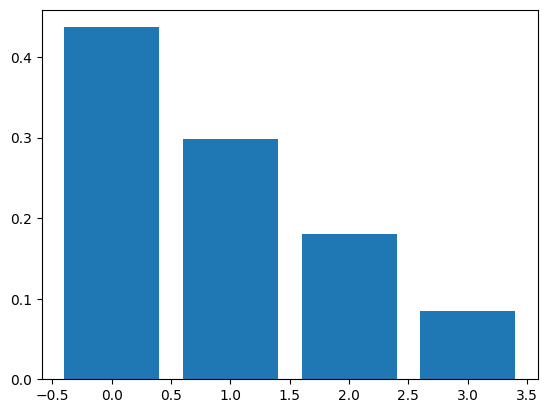

In [88]:
list_log_prob = model.predict_with_gibbs(torch.randn(500,2)*0.125,prior)
print(list_log_prob)
plt.bar(range(4), list_log_prob)
plt.show()

In [89]:
print(mean_posterior.mean(0))

tensor([[ 1.5373,  1.5235],
        [ 1.5125, -1.5793],
        [-1.4834, -1.5247],
        [-1.5419,  1.4828]])


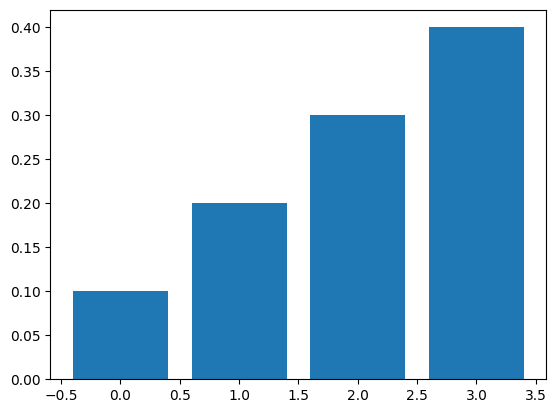

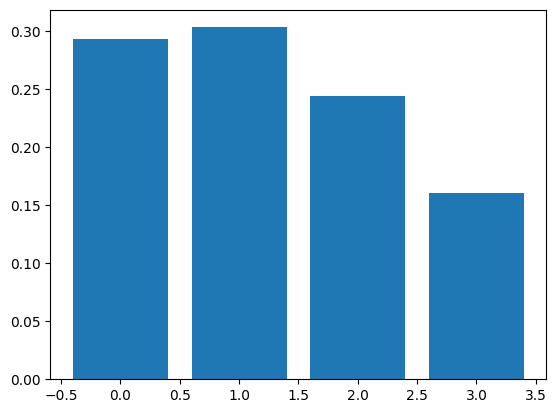

In [90]:
with torch.no_grad():
    plt.bar(range(4),[500*(1/(500+1000+1500+2000)),1000*(1/(500+1000+1500+2000)),1500*(1/(500+1000+1500+2000)),2000*(1/(500+1000+1500+2000))])
    plt.show()
    plt.bar(range(4),torch.mean(torch.exp(model.log_prob(torch.randn(10000,2)*0.25,mean_posterior,Sigma_posterior, prior)), dim = [0,1]))
    plt.show()

In [7]:

d=2
mu_0 = torch.zeros(2)
Psi_0 = torch.eye(2)
lbda = 1
nu = 10

In [ ]:
lbda_N = lbda + N
nu_N = nu + N
empirical_mean = torch.mean(x_N, dim =0)
mu_N = (lbda*mu_0 + N*empirical_mean)/lbda_N
S = torch.cov(x_N.T)*(N-1)
temp = (empirical_mean-mu_0).unsqueeze(-1)
Psi_N = Psi_0 + S + (lbda*N*temp@temp.T)/(lbda_N)

Sigma = torch.inverse(torch.distributions.Wishart(nu_N,torch.inverse(Psi_N)).sample([10000]))
true_mean = torch.distributions.MultivariateNormal(mu_0,true_sigma/lbda).sample()